In [0]:
# google colab does not come with torch installed. And also, in course we are using torch 0.4. 
# so following snippet of code installs the relevant version

from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [8]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [9]:
# we need pillow version of 5.3.0
# we will uninstall the older version first
!pip uninstall -y Pillow
# install the new one
!pip install Pillow==5.3.0
# import the new one
import PIL
print(PIL.PILLOW_VERSION)
# this should print 5.3.0. If it doesn't, then restart your runtime:
# Menu > Runtime > Restart Runtime

Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
  Using cached https://files.pythonhosted.org/packages/62/94/5430ebaa83f91cc7a9f687ff5238e26164a779cca2ef9903232268b0a318/Pillow-5.3.0-cp36-cp36m-manylinux1_x86_64.whl
5.3.0


In [0]:
# This is the contents of helper.py 
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torch.autograd import Variable


def test_network(net, trainloader):

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # Create Variables for the inputs and targets
    inputs = Variable(images)
    targets = Variable(images)

    # Clear the gradients from all Variables
    optimizer.zero_grad()

    # Forward pass, then backward pass, then update weights
    output = net.forward(inputs)
    loss = criterion(output, targets)
    loss.backward()
    optimizer.step()

    return True


def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


def view_recon(img, recon):
    ''' Function for displaying an image (as a PyTorch Tensor) and its
        reconstruction also a PyTorch Tensor
    '''

    fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)
    axes[0].imshow(img.numpy().squeeze())
    axes[1].imshow(recon.data.numpy().squeeze())
    for ax in axes:
        ax.axis('off')
        ax.set_adjustable('box-forced')

def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

In [0]:
#first step is loading and visualizing the data
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets , transforms 

#no of subprocesses used for data loading
num_workers = 0

#batcg_size - no of examples in one go 
batch_size = 64

#no of transforms has to be applied like randomresize,crop,normalize but here we are just using totensor to convert image to tensor
transform = transforms.ToTensor()

#getting the whole dataset downloaded and saved in a object train_data/tes_data
train_data = datasets.MNIST(root = 'data' , train = True , download  = True , transform = transform) 

test_data = datasets.MNIST(root = 'data' , train = False , download  = True , transform = transform)

#creating a object train_loader to get batches of data 
trainloader = torch.utils.data.DataLoader(train_data , batch_size = batch_size , num_workers = num_workers)

testloader = torch.utils.data.DataLoader(test_data , batch_size = batch_size , num_workers = num_workers)

In [13]:
#total training data
len(train_data)

60000

In [14]:
#total testing data
len(test_data)

10000

In [16]:
#total batches of training data
len(trainloader)

938

In [17]:
#total batches of testing data
len(testloader)

157

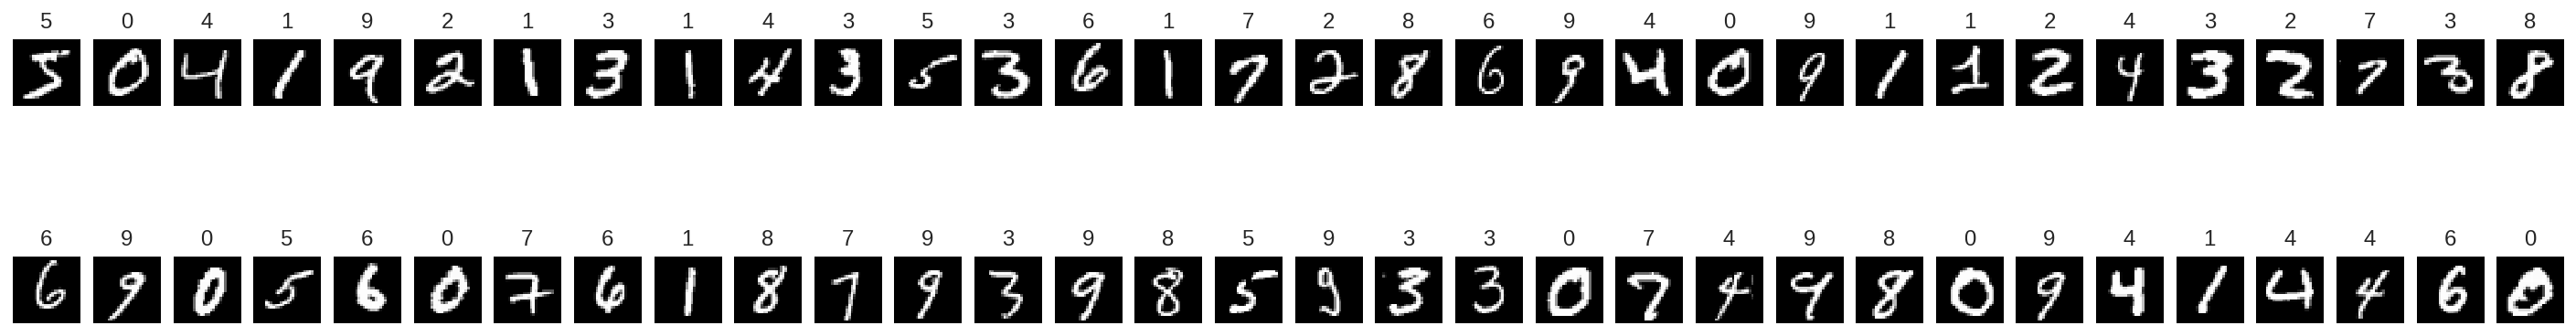

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(64):
    ax = fig.add_subplot(2, 64/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

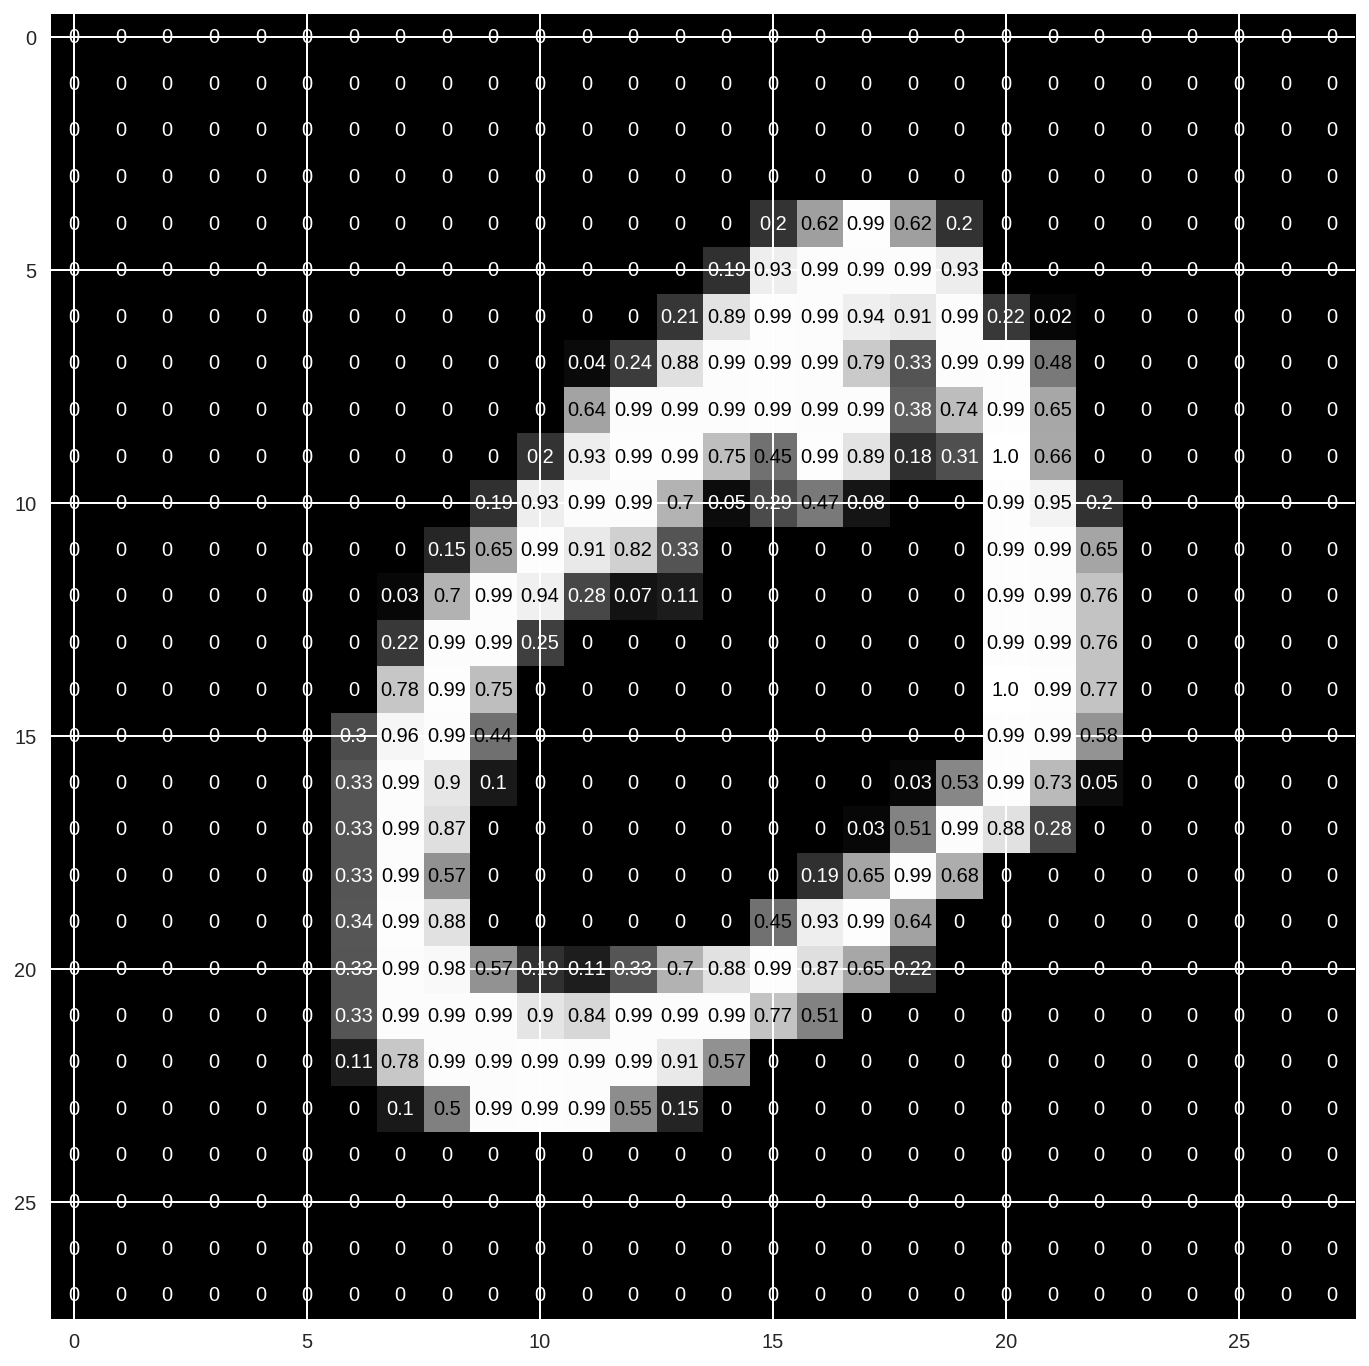

In [20]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

In [21]:
# number of hidden nodes in each layer (512)
# linear layer (784 -> hidden_1)
# linear layer (n_hidden -> hidden_2)
# linear layer (n_hidden -> 10)
# dropout layer (p=0.2)  dropout prevents overfitting of data
# add hidden layer, with relu activation function
# add output layer
model = nn.Sequential(nn.Linear(784,512),nn.ReLU(),nn.Dropout(0.2),nn.Linear(512,512),nn.ReLU(),nn.Dropout(0.2),nn.Linear(512,10),nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

optimizer = torch.optim.SGD(model.parameters() , lr = 0.01)
# number of epochs to train the model

epochs = 50

#to have a history of losses to plot the graph
train_losses , test_losses = [] , []

#to put the model in training mode
model.train()
for epoch in range(epochs):
  running_loss = 0
  for images , labels in trainloader:
    # clear the gradients of all optimized variables
    optimizer.zero_grad()
    #flatten the image
    images = images.flatten(start_dim=1)
    #forward pass (feed forward)forward pass: compute predicted outputs by passing inputs to the model
    outputs = model(images)
    # calculate the loss
    loss = criterion(outputs,labels)
    #gradient descent ,backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()
    # perform a single optimization step (parameter update)
    optimizer.step()
    # update running training loss
    running_loss += loss.item()
    
  # initialize lists to monitor test loss and accuracy
  test_loss = 0
  accuracy = 0
  #we no longer gradients to be calculated
  with torch.no_grad():
    model.eval() # prep model for evaluation
    for images , labels in testloader:
      images = images.flatten(start_dim=1) #flattening the image
      logps = model(images) # forward pass: compute predicted outputs by passing inputs to the model
      test_loss += criterion(logps,labels) #calculate the loss and update the loss
      ps = torch.exp(logps)
      top_p , top_class = ps.topk(1,dim=1)
      equals = top_class == labels.view(*top_class.shape)
      accuracy += torch.mean(equals.type(torch.FloatTensor))    
   
  train_losses.append(running_loss/len(trainloader))
  test_losses.append(test_loss/len(testloader))
  print("Epoch: {}/{}.. ".format(epoch+1, epochs),"Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),"Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),"Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
  model.train()    
        
  

Epoch: 1/50..  Training Loss: 1.600..  Test Loss: 0.676..  Test Accuracy: 0.826
Epoch: 2/50..  Training Loss: 0.557..  Test Loss: 0.403..  Test Accuracy: 0.887
Epoch: 3/50..  Training Loss: 0.418..  Test Loss: 0.336..  Test Accuracy: 0.905
Epoch: 4/50..  Training Loss: 0.362..  Test Loss: 0.301..  Test Accuracy: 0.914
Epoch: 5/50..  Training Loss: 0.329..  Test Loss: 0.275..  Test Accuracy: 0.920
Epoch: 6/50..  Training Loss: 0.302..  Test Loss: 0.255..  Test Accuracy: 0.928
Epoch: 7/50..  Training Loss: 0.279..  Test Loss: 0.236..  Test Accuracy: 0.933
Epoch: 8/50..  Training Loss: 0.258..  Test Loss: 0.220..  Test Accuracy: 0.936
Epoch: 9/50..  Training Loss: 0.241..  Test Loss: 0.205..  Test Accuracy: 0.941
Epoch: 10/50..  Training Loss: 0.225..  Test Loss: 0.191..  Test Accuracy: 0.944
Epoch: 11/50..  Training Loss: 0.210..  Test Loss: 0.180..  Test Accuracy: 0.947
Epoch: 12/50..  Training Loss: 0.199..  Test Loss: 0.169..  Test Accuracy: 0.950
Epoch: 13/50..  Training Loss: 0.187.

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [0]:
# obtain one batch of test images
dataiter = iter(testloader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))